<font color='black'> <h1>CS 230 Final Project - Simple VAE with Deep Sphere </h1> </font>
<font color='darkslateblue'> <h4> by Emmy Li </h4> </font>
<font color='darkslateblue'> <h4> February 17, 2021 </h4> </font>
***

<h2>Introduction</h2>

Just messing around to see what sticks


<font color='slateblue'>Cosmic Microwave Background Radiation</font> is the oldest electromagnetic radiation in the universe and thought to be a remnant of the explosive origins of the early universe. Discovered in 1965 by Arno Penzias and Robert Wilson, data from the Cosmic Microwave Background (CMB) continues to grow with significant contributions from the Cosmic Background Explorer (COBE), the Wilkinson microwave Anisotropy Probe (WMAP), and most recently, Planck which measure the fluctuations of the CMB. Processing this data efficiently and accurately promises to unlock a wealth of understanding about the origins and evolution of our universe. In particular, having the ability to generate cross-correlations of CMB temperature and polarization maps with other maps produced from separate large-scale optical surveys would allow for a greater precision of CMB measurements. Due the small scale of the anisotropies of the CMB, astronomical equipment must be extremely sensitive, however, non-Gaussian interference due to extragalactic radio sources, dust emission, and other noise along the galactic line of sight muddies the signal. <font color='slateblue'>Studying ways to spatially correlate CMB maps with the fluxes of other astronomical objects would contribute to a finer disentangling of signal and noise.</font>

[(available here)]: https://act.princeton.edu/sites/act/files/epo_report_nov4_feedbackform.pdf




## Generative Models

We're trying to transpose pseudo convolutions in DeepSphere to train a simple auto-encoder. We're trying to take the dataset from CosmoVAE's suggested 2018 Planck map and pass it into this routine.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

# tqdm makes loops show a progress meter, valuable during training
from tqdm import tqdm

We start by loading in the data from Planck to see if we can get HealPIX to slice it up.

Our toy model seems to have two classes with 100 values each?

In [16]:
data = np.load('/Users/emmyli/deepsphere-cosmo-tf2/data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))

nclass = len(data['class1'])

In [49]:
data['class1'].shape

(100, 49152)

In [53]:
training_data = []

# for every row in class 1, reorder the pixels from nested to ring ordering in order
# perform smoothing, and then revert it back again
for m in data['class1']:
    m = hp.reorder(m, n2r=True)
    m = hp.smoothing(m, fwhm=.05, verbose=False)
    m = hp.reorder(m, r2n=True)
    training_data.append(100*m.astype(np.float32)[:,None])
# training_data = np.array(training_data)
print(len(training_data))

100


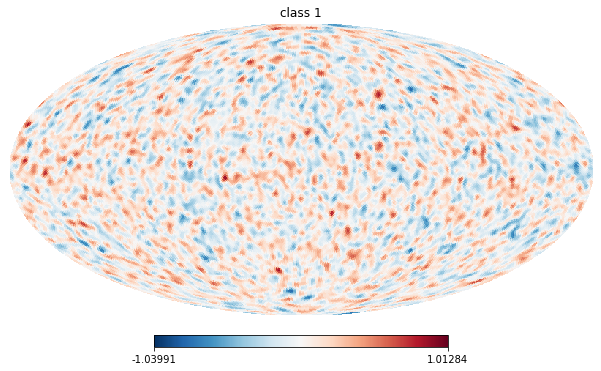

In [46]:
cmin = np.min(training_data)
cmax = np.max(training_data)
cm = plt.cm.RdBu_r
hp.mollview(training_data[0,:,0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)

In [7]:
class auto_encoder(tf.keras.Model):
    def __init__(self, encoder_layer, decoder_layer, nside, indices):
        """
        Inits the auto-encoder with layers for the encoder and the decoder
        """
        # this line is necessary for all Model subclasses
        super(auto_encoder, self).__init__(name="")
        
        # save some properties
        self.nside = nside
        self.indices = indices
        
        # init the encoder and the decoder
        print("Initializing the encoder...")
        self.encoder = HealpyGCNN(nside=nside, indices=indices, layers=encoder_layer,
                                  n_neighbors=20)
        
        # get the bottle neck nside and indices
        self.bottle_neck_nside = self.encoder.nside_out
        self.bottle_neck_indices = self.encoder._transform_indices(nside_in=self.nside, 
                                                        nside_out=self.bottle_neck_nside, 
                                                        indices=self.indices)
        
        print("Initializing the decoder...")
        self.decoder = HealpyGCNN(nside=self.bottle_neck_nside, 
                                  indices=self.bottle_neck_indices, 
                                  layers=decoder_layer, n_neighbors=20)
        
    def summary(self, *args, **kwargs):
        """
        A wrapper for the summary routines of the decoder and encoder
        """
        print("Encoder summary:")
        self.encoder.summary(*args, **kwargs)
        print("Decoder summary:")
        self.decoder.summary(*args, **kwargs)
        
    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the autoencoder
        """
        bottle_neck = self.encoder(input_tensor, training=training, *args, **kwargs)
        reconstruction = self.decoder(bottle_neck, training=training, *args, **kwargs)
        
        return reconstruction

In [8]:
K = 5
encoder_layers = [hp_layer.HealpyPseudoConv(p=1, Fout=4, activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=8, activation="elu"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),]

decoder_layers = [hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                   activation="elu"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=1, activation="linear")]


In [9]:
nside = 64
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
model = auto_encoder(encoder_layers, decoder_layers, nside, indices)
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

Initializing the encoder...
Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Initializing the decoder...
Detected a reduction factor of 0.125, the input with nside 8 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Encoder summary:
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
healpy_pseudo_conv (HealpyPseudoConv)            (None, 12288, 4)                            20               
______________________________________________________________________________________________________________
healpy_pseudo_conv_1 (HealpyPseudoConv)          (None, 3072, 8)                             136          

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss="MAE",
              metrics=["MAE"],
)


In [12]:
print("Fit model on training data")
history = model.fit(
    x=training_data,
    y=training_data,
    batch_size=5,
    epochs=50,
)

Fit model on training data
Epoch 1/50
20/20 [==============================] - 5s 147ms/step - loss: 0.1846 - MAE: 0.1846
Epoch 2/50
20/20 [==============================] - 3s 144ms/step - loss: 0.1110 - MAE: 0.1110
Epoch 3/50
20/20 [==============================] - 3s 136ms/step - loss: 0.1007 - MAE: 0.1007
Epoch 4/50
20/20 [==============================] - 3s 134ms/step - loss: 0.0973 - MAE: 0.0973
Epoch 5/50
20/20 [==============================] - 3s 134ms/step - loss: 0.0959 - MAE: 0.0959
Epoch 6/50
20/20 [==============================] - 3s 135ms/step - loss: 0.0952 - MAE: 0.0952
Epoch 7/50
20/20 [==============================] - 3s 135ms/step - loss: 0.0948 - MAE: 0.0948
Epoch 8/50
20/20 [==============================] - 3s 135ms/step - loss: 0.0926 - MAE: 0.0926
Epoch 9/50
20/20 [==============================] - 3s 135ms/step - loss: 0.0890 - MAE: 0.0890
Epoch 10/50
20/20 [==============================] - 3s 134ms/step - loss: 0.0841 - MAE: 0.0841
Epoch 11/50
20/20 [===

In [13]:
original_map = training_data[:1]
reconstructed_map = model(original_map, True).numpy()

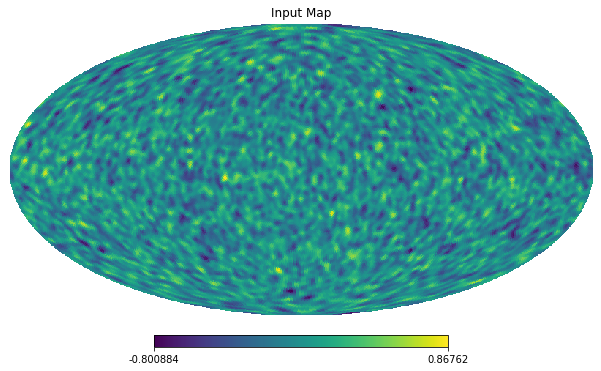

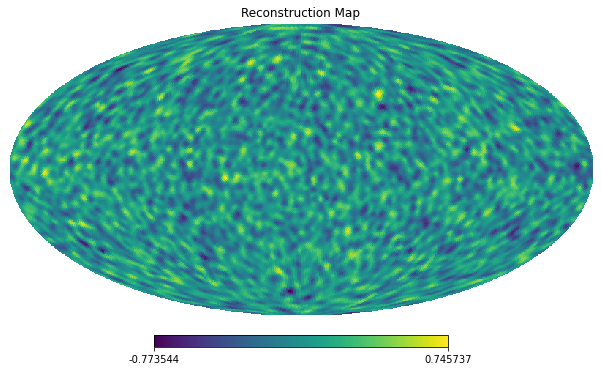

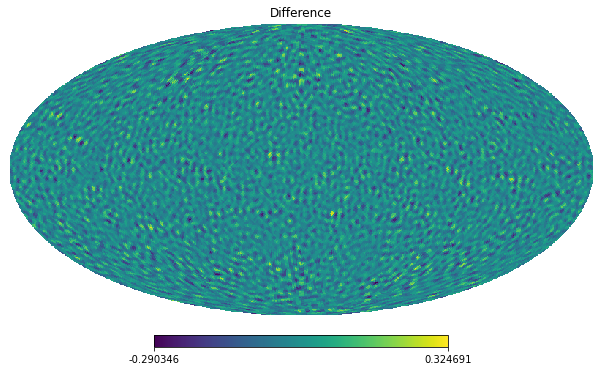

In [14]:
hp.mollview(original_map[0,:,0], nest=True, title="Input Map")
hp.mollview(reconstructed_map[0,:,0], nest=True, title="Reconstruction Map")
hp.mollview(original_map[0,:,0] - reconstructed_map[0,:,0], nest=True, title="Difference")

Text(0, 0.5, 'Loss')

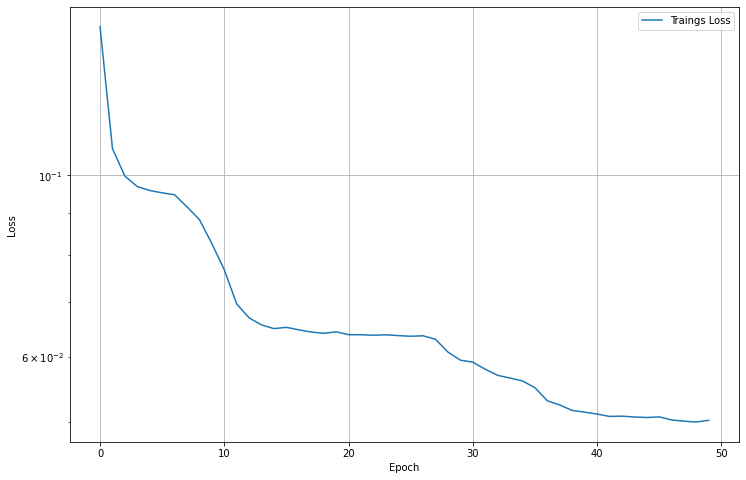

In [15]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="Traings Loss")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")